## Clustering with Customer Segmentation

My intention with this notebook is to explore techniques for clustering and how this is incorporated into RFM analysis.

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.cluster import KMeans

In [4]:
orders = pd.read_csv("orders.csv")

In [8]:
order_products_prior = pd.read_csv("order_products__prior.csv")

In [7]:
order_products_train = pd.read_csv("order_products__train.csv")

In [10]:
order_products = pd.concat([order_products_prior, order_products_train], axis = 0)

In [12]:
order_products.shape

(33819106, 4)

In [13]:
len(order_products_prior) + len(order_products_train)

33819106

In [14]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [15]:
order_products = order_products.sort_values(by = "order_id")

In [16]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0


In [17]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [19]:
orders = orders.dropna()

In [21]:
order_df = pd.merge(orders, order_products, how = "right", on = "order_id")

In [22]:
order_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2398795,1.0,prior,2.0,3.0,7.0,15.0,26088,5,1
1,2398795,1.0,prior,2.0,3.0,7.0,15.0,13032,6,0
2,2398795,1.0,prior,2.0,3.0,7.0,15.0,12427,3,1
3,2398795,1.0,prior,2.0,3.0,7.0,15.0,10258,2,0
4,2398795,1.0,prior,2.0,3.0,7.0,15.0,13176,4,0


In [28]:
orders_by_cust = order_df[['user_id', 'order_id']].groupby(['user_id']).count()

In [31]:
orders_by_cust.rename(columns = {"order_id": "number of orders"}, inplace = True)

In [32]:
orders_by_cust

,number of orders
user_id,
1.0,65
2.0,213
3.0,78
4.0,14
5.0,35
...,...
206205.0,34
206206.0,281
206207.0,199


### RFM analysis

I want to engineer three features that approximate Recency, Frequency and Monetary value. Monetary value is approximated by number of products per order, which isn't the most accurate proxy.

Average lag per customer approximates Recency and Frequency is approximated by number of orders.

In [49]:
average_days_between = order_df[['user_id', 'days_since_prior_order']].groupby(['user_id']).mean()

In [50]:
average_days_between.rename(columns = {"days_since_prior_order": "average lag per customer"}, inplace = True)

In [51]:
average_days_between

,average lag per customer
user_id,
1.0,19.200000
2.0,18.009390
3.0,11.487179
4.0,15.357143
5.0,12.314286
...,...
206205.0,14.705882
206206.0,4.042705
206207.0,14.879397


In [56]:
average_order_size = order_df[['user_id', 'order_id', 'add_to_cart_order']].groupby(['order_id']).max()

In [58]:
average_order_size.sort_values(by = 'user_id')

,user_id,add_to_cart_order
order_id,,
550135,1.0,5
2398795,1.0,6
431534,1.0,8
473747,1.0,5
3367565,1.0,4
...,...,...
3421024,NaN,5
3421044,NaN,11
3421046,NaN,8


In [61]:
average_order_size.rename(columns = {"add_to_cart_order": "order size"}, inplace = True)

In [62]:
average_order_size.sort_values(by = 'user_id')

,user_id,order size
order_id,,
550135,1.0,5
2398795,1.0,6
431534,1.0,8
473747,1.0,5
3367565,1.0,4
...,...,...
3421024,NaN,5
3421044,NaN,11
3421046,NaN,8


In [66]:
average_order_size = average_order_size[['user_id', 'order size']].groupby(['user_id']).mean()

In [68]:
average_order_size.rename(columns = {"order size": "average order size"}, inplace = True)

In [69]:
average_order_size

,average order size
user_id,
1.0,6.500000
2.0,15.214286
3.0,7.090909
4.0,3.500000
5.0,8.750000
...,...
206205.0,11.333333
206206.0,4.257576
206207.0,13.266667


In [172]:
RFM = pd.concat([orders_by_cust, average_days_between.iloc[:, 0], average_order_size.iloc[:, 0]], axis = 1)

In [173]:
RFM

,number of orders,average lag per customer,average order size
user_id,,,
1.0,65,19.200000,6.500000
2.0,213,18.009390,15.214286
3.0,78,11.487179,7.090909
4.0,14,15.357143,3.500000
5.0,35,12.314286,8.750000
...,...,...,...
206205.0,34,14.705882,11.333333
206206.0,281,4.042705,4.257576
206207.0,199,14.879397,13.266667


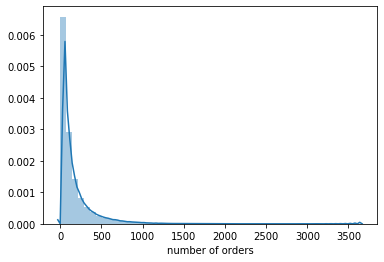

In [88]:
sns.distplot(RFM['number of orders'])

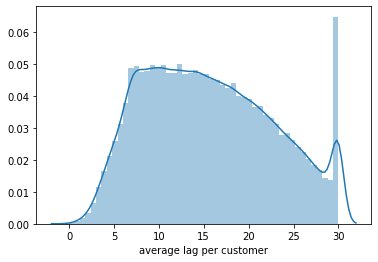

In [89]:
sns.distplot(RFM['average lag per customer'])

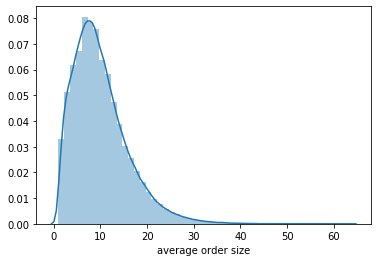

In [90]:
sns.distplot(RFM['average order size'])

In [174]:
columns = ['number of orders', 'average lag per customer', 'average order size']

I need to log transform the data and scale it so that k means clustering can actually work.

In [175]:
len(RFM[RFM['average lag per customer'] == 0])
len(RFM[RFM['average order size'] == 0])

0

In [176]:
RFM = RFM[(RFM != 0).all(1)]

In [177]:
len(RFM)

206195

In [178]:
RFM = RFM.dropna()

In [179]:
len(RFM)

206195

In [181]:
RFM_log = copy.copy(RFM)

In [182]:
for i in columns:
   RFM_log[i] = np.log(RFM_log[i]) 

In [183]:
RFM_log.describe()

,number of orders,average lag per customer,average order size
count,206195.000000,206195.000000,206195.000000
mean,4.390963,2.626543,2.114869
std,1.169864,0.530103,0.648822
min,0.693147,-2.639057,0.000000
25%,3.583519,2.283493,1.742969
50%,4.382027,2.708050,2.197225
75%,5.214936,3.040546,2.564949
max,8.198639,3.401197,4.147095


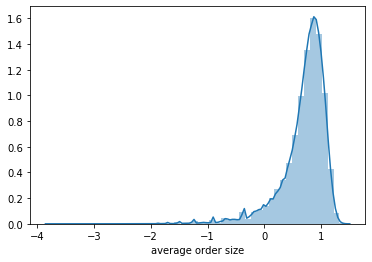

In [106]:
sns.distplot(RFM['average order size'])

In [155]:
#RFM_log = RFM_log[(RFM_log > -1).all(1)]

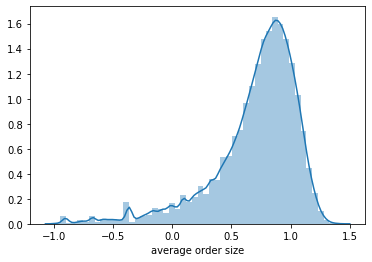

In [109]:
sns.distplot(RFM['average order size'])

In [185]:
len(RFM_log)

206195

In [186]:
RFM_log.columns

Index(['number of orders', 'average lag per customer', 'average order size'], dtype='object')

In [187]:
sc = StandardScaler()
RFM_log = sc.fit_transform(RFM_log)
RFM_log

array([[-0.18512975,  0.61944227, -0.37462893],
       [ 0.82943927,  0.49867869,  0.93610665],
       [-0.02928087, -0.3495764 , -0.24052201],
       ...,
       [ 0.77132353,  0.13852955,  0.72498489],
       [ 1.80262729, -1.16843362,  0.79176974],
       [ 0.36698217,  0.77977598,  0.21648954]])

In [188]:
#X = RFM_log[['number of orders' , 'average lag per customer', 'average order size']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    kmeans = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 1  , algorithm='full') )
    kmeans.fit(RFM_log)
    inertia.append(kmeans.inertia_)

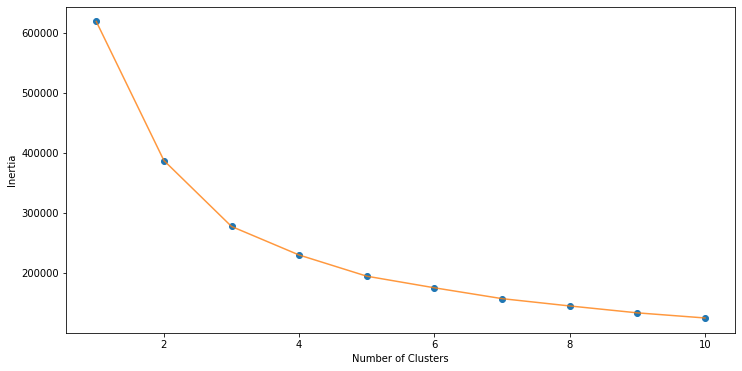

In [189]:
plt.figure(1 , figsize = (12 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.8)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [192]:
len(RFM_log)

206195

In [193]:
kmeans = KMeans(n_clusters = 3 ,init='k-means++', n_init = 10 ,max_iter=300, tol=0.0001,  random_state= 1  , algorithm='full').fit(RFM_log) 

In [194]:
len(kmeans.labels_)

206195

,number of orders,average lag per customer,average order size
user_id,,,
1.0,65,19.200000,6.500000
2.0,213,18.009390,15.214286
3.0,78,11.487179,7.090909
4.0,14,15.357143,3.500000
5.0,35,12.314286,8.750000
...,...,...,...
206205.0,34,14.705882,11.333333
206206.0,281,4.042705,4.257576
206207.0,199,14.879397,13.266667


In [165]:
RFM_log = RFM_log[(RFM_log != 0).all(1)]

In [196]:
RFM['cluster'] = kmeans.labels_

In [197]:
RFM['cluster']

user_id
1.0         1
2.0         1
3.0         1
4.0         2
5.0         1
           ..
206205.0    1
206206.0    0
206207.0    1
206208.0    0
206209.0    1
Name: cluster, Length: 206195, dtype: int32

In [198]:
RFM.reset_index()

,user_id,number of orders,average lag per customer,average order size,cluster
0,1.0,65,19.200000,6.500000,1
1,2.0,213,18.009390,15.214286,1
2,3.0,78,11.487179,7.090909,1
3,4.0,14,15.357143,3.500000,2
4,5.0,35,12.314286,8.750000,1
...,...,...,...,...,...
206190,206205.0,34,14.705882,11.333333,1
206191,206206.0,281,4.042705,4.257576,0
206192,206207.0,199,14.879397,13.266667,1
206193,206208.0,665,7.442105,13.854167,0


In [199]:
average_metrics = pd.pivot_table(RFM, values = ['number of orders', 'average lag per customer', 'average order size'],
                                index = 'cluster', aggfunc = np.mean)

In [200]:
average_metrics

,average lag per customer,average order size,number of orders
cluster,,,
0,8.238673,11.293287,330.895794
1,19.219301,12.659914,104.569988
2,18.408770,4.200848,28.920028


In [238]:
RFM.describe()

,Frequency,Recency,MonetaryApprox,cluster
count,206195.000000,206195.000000,206195.000000,206195.000000
mean,153.936177,15.632389,9.990373,0.958956
std,203.393576,7.089732,5.933462,0.755860
min,2.000000,0.071429,1.000000,0.000000
25%,36.000000,9.810893,5.714286,0.000000
50%,80.000000,15.000000,9.000000,1.000000
75%,184.000000,20.916667,13.000000,2.000000
max,3636.000000,30.000000,63.250000,2.000000


In [201]:
RFM['cluster'].value_counts()

1    88044
0    63307
2    54844
Name: cluster, dtype: int64

So the first cluster appear to have high recency, high order size (Monetary approx.) and a high number of orders (Frequency). The second cluster has low recency, high order size and medium frequency. The last cluster has low recency, low order size and low frequency.

The weight for each feature in RFM is dependent upon the industry. For example, in an industry with durable goods, the frequenc will not be weighed heavily and monetary value will be weighed highly.

Saying this, given that one cluster is low on every metric (cluster 2) and one is high in every metric, it appears that cluster 0 is most important and cluster 2 is least.

I now want to analyze patterns in these three clusters. One possibilty is looking at the time series of each cluster to understand the extent to which business is declining or improving as a result of changing behaviour in each cluster. The problem with this is that I don't have dates other than day of the week. Instead I could use the 

In [239]:
RFM = RFM.rename(columns = {'average lag per customer': "Recency", 'number of orders': "Frequency", 'average order size': "MonetaryApprox"})

In [240]:
def quantile(df, metric, start_q, end_q, increment):
    category = range(start_q, end_q, increment)
    quantiles = pd.qcut(df[metric], q=abs(
        end_q - start_q), labels = category)
    df = df.assign(name = quantiles.values)
    metric_name = metric + ' quantile'
    
    return df.rename(columns={"name": metric_name})

In [241]:
RFM_quantile = RFM.copy()

In [242]:
RFM.columns

Index(['Frequency', 'Recency', 'MonetaryApprox', 'cluster'], dtype='object')

In [243]:
RFM

,Frequency,Recency,MonetaryApprox,cluster
user_id,,,,
1.0,65,19.200000,6.500000,1
2.0,213,18.009390,15.214286,1
3.0,78,11.487179,7.090909,1
4.0,14,15.357143,3.500000,2
5.0,35,12.314286,8.750000,1
...,...,...,...,...
206205.0,34,14.705882,11.333333,1
206206.0,281,4.042705,4.257576,0
206207.0,199,14.879397,13.266667,1


In [244]:
RFM_quantile = quantile(RFM_quantile, 'Recency', 4, 0, -1)
RFM_quantile = quantile(RFM_quantile, 'Frequency', 1, 5, 1)
RFM_quantile = quantile(RFM_quantile, 'MonetaryApprox', 1, 5, 1)

RFM_quantile.head()

,Frequency,Recency,MonetaryApprox,cluster,Recency quantile,Frequency quantile,MonetaryApprox quantile
user_id,,,,,,,
1.0,65,19.200000,6.500000,1,2,2,2
2.0,213,18.009390,15.214286,1,2,4,4
3.0,78,11.487179,7.090909,1,3,2,2
4.0,14,15.357143,3.500000,2,2,1,1
5.0,35,12.314286,8.750000,1,3,1,2


In [247]:
def rfm_combined(s): 
    return str(s['Recency quantile']) + str(s['Frequency quantile']) + str(s['MonetaryApprox quantile'])

In [248]:
RFM_quantile['RFM_Segment'] = RFM_quantile.apply(rfm_combined, axis=1)
RFM_quantile.head()

,Frequency,Recency,MonetaryApprox,cluster,Recency quantile,Frequency quantile,MonetaryApprox quantile,RFM_Segment
user_id,,,,,,,,
1.0,65,19.200000,6.500000,1,2,2,2,222
2.0,213,18.009390,15.214286,1,2,4,4,244
3.0,78,11.487179,7.090909,1,3,2,2,322
4.0,14,15.357143,3.500000,2,2,1,1,211
5.0,35,12.314286,8.750000,1,3,1,2,312


In [252]:
pop_freq = RFM_quantile['Frequency'].mean()
pop_recency = RFM_quantile['Recency'].mean()
pop_MonetaryApprox = RFM_quantile['MonetaryApprox'].mean()

In [251]:
relative_import = pd.DataFrame()
for i in :
    cluster_mean = df.groupby(['cluster']).mean()

In [254]:
def relative_import(row, df, df2): 
    df2['rel_importance_freq'] = df2['average lag per customer'] / df['Frequency'].mean()
    df2['rel_importance_rec'] = df2['average order size'] / df['Recency'].mean()
    df2['rel_importance_mon'] = df2['number of orders'] / df['MonetaryApprox'].mean()

In [279]:
average_metrics.apply(lambda row: relative_import(row, RFM, average_metrics), axis = 1)

cluster
0    None
1    None
2    None
dtype: object

In [280]:
average_metrics

,average lag per customer,average order size,number of orders,rel_importance_freq,rel_importance_rec,rel_importance_mon
cluster,,,,,,
0,8.238673,11.293287,330.895794,0.053520,0.722429,33.121466
1,19.219301,12.659914,104.569988,0.124852,0.809852,10.467076
2,18.408770,4.200848,28.920028,0.119587,0.268727,2.894790


In [259]:
RFM['Frequency'].mean()

153.9361769199059

There are other ways to estimate the optimal number of clusters. One other way is through the silhoulette score. The silhoulette method measures the degree to which a point is similar to its own cluster relative to other clusters. The possible values range from -1 to 1, with 1 indicating there is a lot of similarity between the point and its cluster. The goal is to maximize this score. If the score is low this indicates that there may be too few or not enough clusters.

In [260]:
from sklearn.metrics import silhouette_score

In [274]:
sil_score = []
kmax = 11

for k in range(2, kmax):
  km = KMeans(n_clusters = k).fit(RFM_log)
  labels = km.labels_
  sil_score.append(silhouette_score(RFM_log, labels, metric = 'euclidean', sample_size = 5000))

In [276]:
sil_score

[0.3242824150519221,
 0.3192403213357318,
 0.3257477658380153,
 0.2799527419047238,
 0.27702350787502356,
 0.26494956522038426,
 0.2572143641588925,
 0.25883792119544513,
 0.25978382833244346]

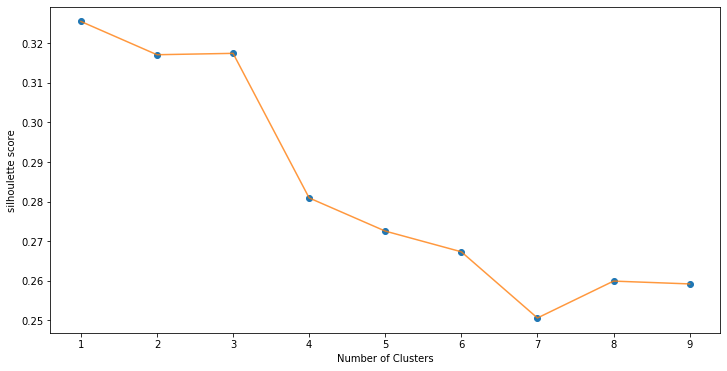

In [277]:
plt.figure(2 , figsize = (12 ,6))
plt.plot(np.arange(1 , 10) , sil , 'o')
plt.plot(np.arange(1 , 10) , sil , '-' , alpha = 0.8)
plt.xlabel('Number of Clusters') , plt.ylabel('silhoulette score')
plt.show()

Although the score for l cluster is higher than 3, I believe more information can be extracted with three clusters, so I think three clusters is the optimal number.

In [281]:
departments = pd.read_csv("departments.csv")

In [282]:
products = pd.read_csv("products.csv")

In [309]:
prod_dep = pd.merge(departments, products, on = "department_id")

In [310]:
prod_dep['department'].value_counts()

personal care      6563
snacks             6264
pantry             5371
beverages          4365
frozen             4007
dairy eggs         3449
household          3085
canned goods       2092
dry goods pasta    1858
produce            1684
bakery             1516
deli               1322
missing            1258
international      1139
breakfast          1115
babies             1081
alcohol            1054
pets                972
meat seafood        907
other               548
bulk                 38
Name: department, dtype: int64

In [286]:
prod_dep.columns

Index(['department_id', 'department', 'product_id', 'product_name',
       'aisle_id'],
      dtype='object')

In [287]:
RFM.columns

Index(['Frequency', 'Recency', 'MonetaryApprox', 'cluster'], dtype='object')

In [288]:
RFM.head()

,Frequency,Recency,MonetaryApprox,cluster
user_id,,,,
1.0,65,19.200000,6.500000,1
2.0,213,18.009390,15.214286,1
3.0,78,11.487179,7.090909,1
4.0,14,15.357143,3.500000,2
5.0,35,12.314286,8.750000,1


In [290]:
order_df.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered'],
      dtype='object')

In [311]:
prod_dep.drop(columns = ['product_name', 'aisle_id'], inplace = True)

In [306]:
order_df = order_df.iloc[:50000, :]

In [312]:
prod_dep = prod_dep.iloc[:50000, :]

In [313]:
ord_dep = pd.merge(order_df, prod_dep, on = "product_id")

In [314]:
len(ord_dep)

50000

In [315]:
ord_dep.isna().sum()

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
department_id             0
department                0
dtype: int64

In [316]:
ord_dep = pd.merge(ord_dep, RFM, on = "user_id")

In [323]:
cluster_dep = pd.pivot_table(ord_dep, values = ['Frequency', 'Recency', 'MonetaryApprox'], index = 'department', aggfunc = np.mean)

In [324]:
cluster_dep

,Frequency,MonetaryApprox,Recency
department,,,
alcohol,333.062500,7.963178,8.158477
babies,648.223714,13.259529,9.132197
bakery,356.585253,13.027726,12.083512
beverages,425.493574,12.363790,10.263216
breakfast,471.116079,12.542250,10.046592
bulk,373.471698,14.027126,12.182333
canned goods,451.789941,14.449620,11.275067
dairy eggs,418.098637,12.906868,11.187915
deli,455.632399,13.692530,11.288333


In [335]:
dep_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,Frequency,Recency,MonetaryApprox,cluster
5049,2639013,64.0,train,11.0,0.0,13.0,27.0,5161,11,0,10,bulk,134,12.880597,13.400000,1
5123,3003586,65.0,prior,4.0,1.0,13.0,1.0,5161,3,0,10,bulk,124,14.653226,8.857143,1
5124,1625976,65.0,prior,5.0,5.0,14.0,4.0,5161,4,1,10,bulk,124,14.653226,8.857143,1
5125,2133732,65.0,prior,6.0,6.0,15.0,15.0,5161,1,1,10,bulk,124,14.653226,8.857143,1
5126,1999119,65.0,prior,7.0,0.0,15.0,1.0,5161,6,1,10,bulk,124,14.653226,8.857143,1
5127,225812,65.0,prior,8.0,1.0,12.0,29.0,5161,5,1,10,bulk,124,14.653226,8.857143,1
5128,3029625,65.0,prior,10.0,1.0,8.0,6.0,5161,4,1,10,bulk,124,14.653226,8.857143,1
5129,692225,65.0,prior,11.0,4.0,9.0,30.0,5161,6,1,10,bulk,124,14.653226,8.857143,1
5130,2630919,65.0,prior,12.0,4.0,8.0,7.0,5161,2,1,10,bulk,124,14.653226,8.857143,1
5131,2028484,65.0,prior,13.0,4.0,15.0,14.0,5161,1,1,10,bulk,124,14.653226,8.857143,1


In [348]:
department_clusters = pd.DataFrame()
for i in ord_dep.department.unique():
    dep_df = ord_dep[ord_dep['department'] == i]
    len_dep = len(dep_df)
    per_cl_0 = len(dep_df[dep_df['cluster'] == 0])/len_dep*100
    per_cl_1 = len(dep_df[dep_df['cluster'] == 1])/len_dep*100
    per_cl_2 = len(dep_df[dep_df['cluster'] == 2])/len_dep*100
    dep_cl = pd.DataFrame(data = {'department' : [i], 'percent cluster 0': [per_cl_0], 'percent cluster 1': [per_cl_1], 'percent cluster 2': [per_cl_2]})
    department_clusters = department_clusters.append(dep_cl, ignore_index = True)

In [349]:
department_clusters

,department,percent cluster 0,percent cluster 1,percent cluster 2
0,snacks,68.363108,25.197341,6.439551
1,breakfast,70.593293,25.795357,3.611350
2,produce,64.901844,30.569601,4.528554
3,beverages,70.169983,23.466003,6.364013
4,dairy eggs,65.315638,30.535629,4.148733
5,pantry,68.147918,28.402735,3.449347
6,household,67.260390,26.802375,5.937235
7,frozen,58.411215,37.414330,4.174455
8,bakery,60.631995,34.891376,4.476629
9,dry goods pasta,62.639821,34.824758,2.535421


In [355]:
department_clusters.sort_values(by = "percent cluster 0", ascending = False)

,department,percent cluster 0,percent cluster 1,percent cluster 2
18,pets,88.297872,8.936170,2.765957
12,alcohol,85.526316,8.223684,6.250000
19,babies,72.930649,22.595078,4.474273
16,missing,71.140940,22.147651,6.711409
1,breakfast,70.593293,25.795357,3.611350
3,beverages,70.169983,23.466003,6.364013
0,snacks,68.363108,25.197341,6.439551
5,pantry,68.147918,28.402735,3.449347
6,household,67.260390,26.802375,5.937235
4,dairy eggs,65.315638,30.535629,4.148733


As seen above, the categories with the highest percent of cluster 0 (which had customers who were most likely to spend, and come back)  were pets, alcohol and babies. This is not too surprising as those are pretty necessary groceries.

There was a sizeable difference in the proportion of orders that were found in cluster 0 and those found in cluster 2. i want to see if this is reflective of the entire dataset.

In [356]:
RFM['cluster'].value_counts()

1    88044
0    63307
2    54844
Name: cluster, dtype: int64

This is not the case and therefore, this is a potential problem in this analysis. Testing on another sample or even several and averaging them could work.

### Future Improvements

if there was time series accompanying the data I could monitor movements in departments and RCF. 

There are more clustering techniques that could be utilizaed. This includes agglomerative clustering and gaussian mixture modelling.

I could look at which clusters change over days of the week.

I could look at how business would improve sales in certain departments based off RFM for those departments.